# Gap Analysis Step 1b: Estimate the AEP and Its Uncertainty Using Cubico Open Data

<div class="alert alert-block alert-info">
Before getting started, be sure that the <code>reanalysis</code> modifier was used for installing OpenOA (i.e., <code>pip install "openoa[reanalysis]"</code>).
</div>

This notebook provides an overview and walk-through of the steps taken to produce a plant-level operational energy asssessment (OA) of a wind plant, using the open data available for [Kelmarsh](https://doi.org/10.5281/zenodo.5841833) and [Penmanshiel](https://doi.org/10.5281/zenodo.5946807).

Uncertainty in the annual energy production (AEP) estimate is calculated through a Monte Carlo approach. Specifically, inputs into the OA code as well as intermediate calculations are randomly sampled based on their specified or calculated uncertainties. By performing the OA assessment thousands of times under different combinations of the random sampling, a distribution of AEP values results from which uncertainty can be deduced. Details on the Monte Carlo approach will be provided throughout this notebook.

**Note**: If the data is not already available on your computer, be sure to install the additionally required packages `cdsapi` (ERA5 API library) and `xarray` (data handling for NetCDF data). This can be done via `pip install "openoa[weather]"` to have have it managed through the OpenOA installation process.

## Step 1: Import the data

Data is downloaded automatically from Zenodo for the wind farm data and from GES DISC and CDS for the long-term reanalysis data. These are then stored in the 'examples/data' folder under the asset names. Note this includes all available data, and so for the 2 assets uses about 20 GB of space in total. The first time this notebook is run it could therefore take a signficant amount of time to download the data (e.g. over an hour). Its recommended that you leave it to run, then restart and run-all to clear the download messages. For downloading the GES DISC and CDS long-term reanalysis data registration is also required, see: [GES DISC registration](https://disc.gsfc.nasa.gov/data-access#python-requests) and [CDS registration](https://cds.climate.copernicus.eu/api-how-to).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from openoa.analysis.aep import MonteCarloAEP
from openoa.utils import plot

from bokeh.plotting import show
# from bokeh.io import output_notebook
# from bokeh.resources import INLINE
# output_notebook(INLINE)

import project_Elexon
import project_Cubico

In [2]:
%load_ext autoreload
%autoreload 2

In the call below, data is loaded using the `project_Cubico.prepare()` function.

In [3]:
assets = project_Elexon.get_Elexon_plant_information()

assets = assets.sort_values("name").set_index("dictionary_id")

In [4]:
results = []

for asset_dictionary_id in assets.index:

    asset = (assets.loc[asset_dictionary_id]["name"]).replace("/","")
    
    file_path = f"data/elexon/{asset_dictionary_id}/result_{asset}.csv"

    if not Path(file_path).exists():

        try:
            project = project_Elexon.prepare(dictionary_id=asset_dictionary_id)

            pa = MonteCarloAEP(project, reanalysis_products = list(project.reanalysis.keys()))

            print(f"{asset}: {pa.aggregate.index[0]} to {pa.aggregate.index[-1]}")

            # Run Monte Carlo based OA
            pa.run(num_sim=10000, reanalysis_products="era5_monthly", outlier_detection=True, operational_months_min=6,operational_months_max=700)

            # Produce histograms of the various MC-parameters
            mc_reg = pd.DataFrame(data={
                'slope': pa._mc_slope.ravel(),
                'intercept': pa._mc_intercept, 
                'num_points': pa._mc_num_points, 
                'metered_energy_fraction': pa.mc_inputs.metered_energy_fraction, 
                'loss_fraction': pa.mc_inputs.loss_fraction,
                'num_years_windiness': pa.mc_inputs.num_years_windiness, 
                'loss_threshold': pa.mc_inputs.loss_threshold,
                'reanalysis_product': pa.mc_inputs.reanalysis_product,
                "operational_months":pa.mc_inputs.operational_months,
            })

            # Boxplot of AEP based on number of years in windiness correction
            # NOTE: This is the same method, but calling the same method through the plot module directly
            box_figure = plot.plot_boxplot(
                y=100*pa.results.aep_GWh/pa.results.aep_GWh.median(),
                x=mc_reg['operational_months'],
                xlabel="Operational months",
                ylabel="AEP percentage of median result (%)",
                plot_kwargs_box={"flierprops":dict(marker="x", markeredgecolor="tab:blue"),},
                figure_kwargs={"figsize":(24, 6)},
                ylim=[80,120],
                return_fig=True,
            )

            box_figure[0].savefig(f"C:/Users/Charlie/Pictures/WindEuropePoster/{asset}.png")

            result = pd.concat([mc_reg,pa.results.aep_GWh],axis=1)

            result.to_csv(file_path)

        except:
            print(f"#####################")
            print(f"#####################")
            print(f"{asset} failed to run")
            print(f"#####################")
            print(f"#####################")

    else:

        result = pd.read_csv(file_path)
    
    results.append(result)

#####################
#####################
Creag Riabhach Wind Farm failed to run
#####################
#####################
#####################
#####################
Dalquhandy Wind Farm failed to run
#####################
#####################
#####################
#####################
Douglas West Wind Farm failed to run
#####################
#####################


  return self._transformer._transform_point(

  return self._transformer._transform_point(



East Anglia: 2019-08-01 00:00:00 to 2024-02-01 00:00:00


  0%|          | 4/10000 [00:00<03:34, 46.52it/s]

#####################
#####################
East Anglia failed to run
#####################
#####################



  return self._transformer._transform_point(

  return self._transformer._transform_point(



Hornsea: 2019-02-01 00:00:00 to 2024-02-01 00:00:00


  0%|          | 7/10000 [00:00<01:53, 88.06it/s]

#####################
#####################
Hornsea failed to run
#####################
#####################
#####################
#####################
Kennoxhead Wind Farm failed to run
#####################
#####################



  return self._transformer._transform_point(

  return self._transformer._transform_point(



Pauls Hill Windfarm: 2021-02-01 00:00:00 to 2024-02-01 00:00:00


  0%|          | 0/10000 [00:00<?, ?it/s]


#####################
#####################
Pauls Hill Windfarm failed to run
#####################
#####################
#####################
#####################
Rothes (Cairn Uish) Wind Farm failed to run
#####################
#####################
#####################
#####################
Sandy Knowe Wind Farm failed to run
#####################
#####################
#####################
#####################
Seagreen Offshore Wind Farm failed to run
#####################
#####################
#####################
#####################
South Kyle Wind Farm failed to run
#####################
#####################
#####################
#####################
Wathegar failed to run
#####################
#####################


In [5]:
aep_trends = []

for result in results:
    aep_trends.append(result[["operational_months","aep_GWh"]].groupby("operational_months").median()/result["aep_GWh"].median())

aep_trend = pd.concat(aep_trends,axis=1)

  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);



Text(0.5, 0, 'Operational months included in the analysis')

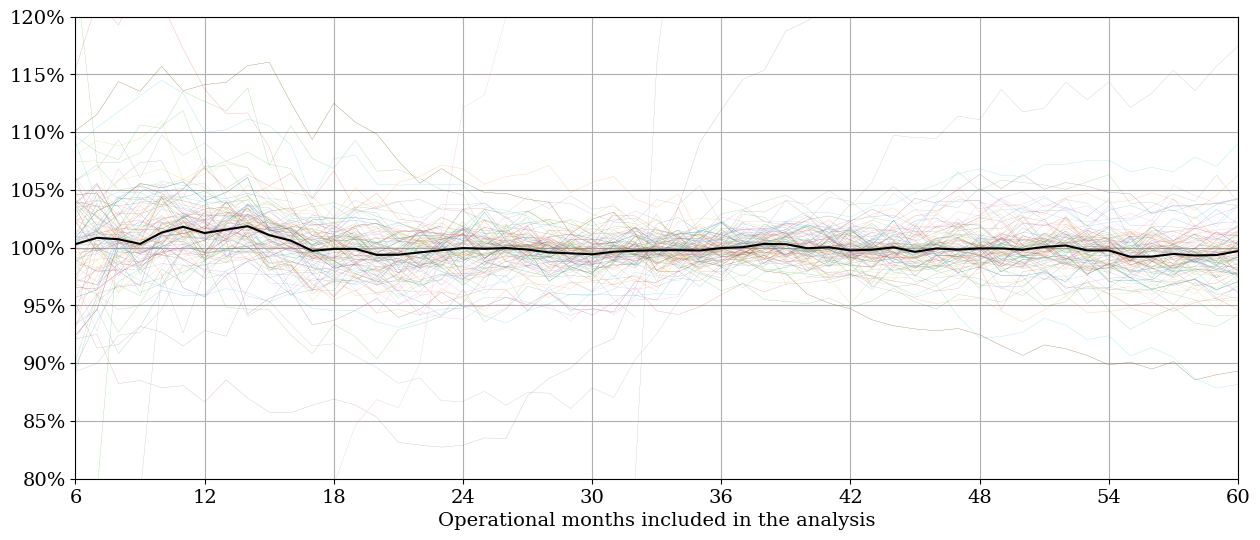

In [15]:
import numpy as np
import matplotlib.ticker as mtick

ax = aep_trend.plot(legend=False,xlim=[6,60],ylim=[0.8,1.2],linewidth=0.1, xticks = (np.arange(0, 61, step=6)) )
aep_trend.median(axis=1).plot(ax=ax,c="black")
# aep_trend.quantile(0.9,axis=1).plot(c="black")
# aep_trend.quantile(0.1,axis=1).plot(c="black")

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
ax.set_xlabel("Operational months included in the analysis")

In [7]:
capacities = project_Elexon.get_Elexon_plant_capacity()

capacities = capacities.set_index("registeredResourceName")

assets["capacity"] = None
for cnt,asset in assets.iterrows():
    
    ngc_bmu_ids = asset["ngc_bmu_id"]

    capacity = 0
    for bmunit in ngc_bmu_ids:
        try:
            bmunit = bmunit.strip()
            capacity = capacity + capacities.loc[bmunit,"installedCapacity"]
        except:
            # print(bmunit)
            capacity = 1

    assets.loc[cnt,"capacity"] = capacity


In [8]:
assets["type"] = "Wind farms"

show(project_Elexon.plot_windfarm(assets,tile_name="ESRI",plot_width=1200,plot_height=1200))